In [8]:
from functools import reduce
import joblib
import datetime
import os
import pandas as pd
import numpy as np
import colorama as col
import yfinance as yf
import pandas_datareader.data as web
#import ffn
from matplotlib import pyplot as plt
import warnings
import joblib
import datetime as dt
#import fxcmpy
from tqdm import tqdm
import sys
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score
sys.path.append('../') 
import pyttsx3
engine = pyttsx3.init()
from scipy.signal import argrelextrema
#from slack_sdk import WebClient
#_slack_token = joblib.load('TOKENS/_slack_token.dag')
#client = WebClient(token=_slack_token)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
import talib
import datetime as dt

warnings.filterwarnings("ignore")

TIK = ['AUD','NZD','GBP','JPY','CHF','CAD','SEK','NOK','ILS','MXN','USD','EUR']
RATE = [0.776,0.721,1.3912,1/105.91,1/0.892,1/1.2681,1/8.2884,1/8.4261,1/3.2385,1/20.1564,1,1.21]
df_ratefx = pd.DataFrame(index=TIK)
df_ratefx['rate'] = RATE

x = 'EUR/USD'
_period = 'm15'
_period2 = 'H1'
_ticker = x.replace('/','')
_start = '2010-01-01' # start the train there '2010-01-01'
_mid = '2016-06-30' # stop the train and begin the test there '2016-08-31'
_stop = '2017-12-31' # stop the test there. After that, it is kept for oos '2017-12-31'
_last = '2021-04-29' # '2020-12-31'
_nb_bougie_exit = 48888888888888
_trigger_reengage = 0
_trigger_target = 1
_trigger_invers = 0
_trigger_sl = 1
_trigger_rsi = 0
_verbose = 0
_cash_ini = 200000
_target = 0.003
_sl = 0.0015
_exposure = 2
_rate = df_ratefx.loc[x[4:],'rate']
_size = _cash_ini / df_ratefx.loc[x[:3],'rate']
_trigger_spread = 0.025
_no_access = 0




_total = 0
_cash_ini = 200000
_cash = _cash_ini
_rate = 1
_flag = 0


_size = 100
_target = 15
_sl = -30
_rsi_high = 65
_rsi_low = 35


In [9]:
def init_base():
  
    """[Première initialisation de la base Live à partir de la base HDD et vérifications d'usage]
    """    
    _t1 = dt.datetime.now()
    print('Début des opérations horodatée à',col.Fore.YELLOW,dt.datetime.now(),col.Style.RESET_ALL)
    
    print('\nINITIALISATION DE LA BASE\n')

    print('Ticker :',col.Fore.YELLOW,x,col.Style.RESET_ALL)

    df,df_H1 = load_hdd()
    
    df = drop_we(df)
    is_we(df)
    
    df_H1 = drop_we(df_H1)
    is_we(df_H1)

    df = make_mid(df)
    
    df_H1 = make_mid(df_H1)

    df = reduce_df(df)

    df_H1 = reduce_df(df_H1)

    #df, df_H1, df_D1, df_W1 =  make_indicators(df, df_H1)

    engine.say("The job is done")
    engine.runAndWait()

    print('Sauvegarde des Bases')
    joblib.dump(df_H1,'BASES/'+_ticker+'_'+_period2)
    joblib.dump(df,'BASES/'+_ticker+'_'+_period)
    #joblib.dump(df_D1,'BASES/'+_ticker+'_D1')
    #joblib.dump(df_W1,'BASES/'+_ticker+'_W1')
    print('Bases sauvegardées')

    engine.say("All the bases are saved")
    engine.runAndWait()

    print('\ndf :',df,'\n')
    print('\ndf_H1 :',df_H1,'\n')
    #print('\ndf_D1 :',df_D1,'\n')
    #print('\ndf_W1 :',df_W1,'\n') 

    #print('\nAnalyse des nan dans df :')
    #check_nan(df)

    #print('\nAnalyse des inf :')
    #check_inf(df)

    #print('\n Analyse des bougies manquantes :')
    #missing_candle_hdd(df)

    _t2 = dt.datetime.now()
    print('Fin des opérations horodatée à',col.Fore.YELLOW,dt.datetime.now(),col.Style.RESET_ALL)
    print('Executé en :',(_t2 - _t1))
    return(df,df_H1)

In [10]:
def peak_detect(price,order=3):
    #print('price.shape',price.shape)
    max_idx = list(argrelextrema(price,np.greater,order=order)[0])
    #print('max_idx shape',len(max_idx))
    min_idx = list(argrelextrema(price,np.less,order=order)[0])
    #print('min_idx shape',len(min_idx))
    idx = max_idx + min_idx + [len(price)-1]
    #print('idx shape',len(idx))
    idx.sort()
    _current_idx = idx[-5:]
    #print('current_idx shape',len(current_idx))
    
    
    _start = min(_current_idx)
    _end = max(_current_idx)
    _current_pat = price[_current_idx]
    return _current_idx,_current_pat,_start,_end  

In [11]:
def is_gartley(moves,err_allowed):  
    XA=moves[0]
    AB=moves[1]
    BC=moves[2]
    CD=moves[3]
   
    AB_range = np.array([0.618 - err_allowed,0.618 + err_allowed])*abs(XA)
    BC_range = np.array([0.382 - err_allowed,0.886 + err_allowed])*abs(AB)
    CD_range = np.array([1.27 - err_allowed,1.618 + err_allowed])*abs(BC)
        
    
    if XA>0 and AB<0 and BC>0 and CD<0:
        
        if AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1]:
            return 1
        else:
            return np.isnan
        
    elif XA<0 and AB>0 and BC<0 and CD>0:
        
               
        if AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1]:
        
            return -1
        else:
            return np.isnan
    else:
        return np.isnan
    
def is_butterfly(moves,err_allowed):  
    
    XA=moves[0]
    AB=moves[1]
    BC=moves[2]
    CD=moves[3]
    
    AB_range = np.array([0.786 - err_allowed,0.786 + err_allowed])*abs(XA)
    BC_range = np.array([0.382 - err_allowed,0.886 + err_allowed])*abs(AB)
    CD_range = np.array([1.618 - err_allowed,2.618 + err_allowed])*abs(BC)
        
    
    if XA>0 and AB<0 and BC>0 and CD<0:
        
        if AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1]:
            return 1
        else:
            return np.NaN
        
    elif XA<0 and AB>0 and BC<0 and CD>0:
        
               
        if AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1]:
        
            return -1
        else:
            return np.isnan
    else:
        return np.isnan       

def is_crab(moves,err_allowed):  
    
    XA=moves[0]
    AB=moves[1]
    BC=moves[2]
    CD=moves[3]
    
    AB_range = np.array([0.382 - err_allowed,0.618 + err_allowed])*abs(XA)
    BC_range = np.array([0.382 - err_allowed,0.886 + err_allowed])*abs(AB)
    CD_range = np.array([2.24 - err_allowed,3.618 + err_allowed])*abs(BC)
        
    
    if XA>0 and AB<0 and BC>0 and CD<0:
        
        if AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1]:
            return 1
        else:
            return np.NaN
        
    elif XA<0 and AB>0 and BC<0 and CD>0:
        
               
        if AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1]:
        
            return -1
        else:
            return np.isnan
    else:
        return np.isnan      
    
def is_bat(moves,err_allowed):  
    
    XA=moves[0]
    AB=moves[1]
    BC=moves[2]
    CD=moves[3]
    
    AB_range = np.array([0.382 - err_allowed,0.5 + err_allowed])*abs(XA)
    BC_range = np.array([0.382 - err_allowed,0.886 + err_allowed])*abs(AB)
    CD_range = np.array([1.618 - err_allowed,2.618 + err_allowed])*abs(BC)
        
    
    if XA>0 and AB<0 and BC>0 and CD<0:
        
        if AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1]:
            return 1
        else:
            return np.NaN
        
    elif XA<0 and AB>0 and BC<0 and CD>0:
        
               
        if AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1]:
        
            return -1
        else:
            return np.isnan
    else:
        return np.isnan
    
def is_abcd(moves,err_allowed):  
    
    AB=moves[1]
    BC=moves[2]
    CD=moves[3]
    
    
    BC_range = np.array([0.618 - err_allowed,0.618 + err_allowed])*abs(AB)
    CD_range = np.array([1.618 - err_allowed,1.618 + err_allowed])*abs(BC)
    CD2_range = np.array([1 - err_allowed,1 + err_allowed])*abs(AB)
    
    
        
    
    if AB<0 and BC>0 and CD<0 :
        
        if BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1] \
        and CD2_range[0]<abs(CD)<CD2_range[1] :
            return 1
        else:
            return np.NaN
        
    elif AB>0 and BC<0 and CD>0 :
        
               
        if BC_range[0]<abs(AB)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1]\
        and CD2_range[0]<abs(CD)<CD2_range[1]:
        
            return -1
        else:
            return np.isnan
    else:
        return np.isnan    
    
def is_shark(moves,err_allowed):  
    
    XA=moves[0]
    AB=moves[1]
    BC=moves[2]
    CD=moves[3]
  
    
    #CD_range = np.array([0.886 - err_allowed,1.13 + err_allowed])*abs(XB)
    BC_range = np.array([1.13 - err_allowed,1.618 + err_allowed])*abs(AB)
    CD_range = np.array([1.618 - err_allowed,2.24 + err_allowed])*abs(BC)
    CD_range2 = np.array([0.88 - err_allowed,1.13 + err_allowed])*abs(XA)   
    
    if XA>0 and AB<0 and BC>0 and CD<0 :
        
        if BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1] and CD_range2[0]<abs(XA)<CD_range2[1]:
            return 1
        else:
            return np.NaN
        
    elif XA<0 and AB>0 and BC<0 and CD>0 :
        
               
        if  BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1] and CD_range2[0]<abs(XA)<CD_range2[1]:
        
            return -1
        else:
            return np.isnan
    else:
        return np.isnan  

In [12]:
def load_hdd():

    engine.say("Loading raw data")
    engine.runAndWait()
    
    df = pd.read_csv('HDD/'+_ticker+'_'+_period+'_BidAndAsk.csv')

    ##### Ajout de la colonne Symbol pour identifier le ticker
    df['Symbol'] = _ticker

    ##### On fixe la date en index sous forme de Timestamp
    df['Lindex'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df.set_index(pd.to_datetime(df.Lindex,format='%Y-%m-%d %H:%M:%S'),drop=True,inplace=True)

    ###### On drop les colonnes inutiles
    df = df.drop(['Date','Lindex','Time','Total Ticks'],axis=1)


    df_H1 = pd.read_csv('HDD/'+_ticker+'_'+_period2+'_BidAndAsk.csv')

    ##### Ajout de la colonne Symbol pour identifier le ticker
    df_H1['Symbol'] = _ticker

    ##### On fixe la date en index sous forme de Timestamp
    df_H1['Lindex'] = pd.to_datetime(df_H1['Date'] + ' ' + df_H1['Time'])
    df_H1.set_index(pd.to_datetime(df_H1.Lindex,format='%Y-%m-%d %H:%M:%S'),drop=True,inplace=True)

    ###### On drop les colonnes inutiles
    df_H1 = df_H1.drop(['Date','Lindex','Time','Total Ticks'],axis=1)

    engine.say("Raw data are loaded")
    engine.runAndWait()    
    return(df,df_H1)

In [13]:
def drop_we(df):
    df['WE'] = np.where(((df.index.weekday == 5) | (df.index.weekday == 6)),None,df.index.weekday)
    df = df.dropna()
    df = df.drop(['WE'],axis=1)
    return(df)

In [14]:
def make_mid(df):
    df['Open'] = (df.OpenAsk + df.OpenBid)/2
    df['High'] = (df.HighAsk + df.HighBid)/2
    df['Low'] = (df.LowAsk + df.LowBid)/2
    df['Close'] = (df.CloseAsk + df.CloseBid)/2
    df['Symbol'] = _ticker
    df['Date'] = df.index
    df['Date'] = pd.to_datetime(df['Date'].dt.strftime(date_format='%Y-%m-%d'))
    df = drop_we(df)
    return(df)

In [15]:
def is_we(dataframe_to_check):
    IDX = dataframe_to_check.index.to_list()
    c=0
    for day in tqdm(IDX):
        if day.weekday() == 5 or day.weekday() == 6:
            c += 1
    print('Nombre de samedi et dimanches présents :',c)

In [16]:
def reduce_df(df):
    df = df[['Close','CloseAsk','CloseBid','High','HighAsk','HighBid','Low','LowAsk','LowBid','Open','OpenAsk','OpenBid','Symbol','Date']]
    return(df)

In [17]:
 #df,df_H1 = init_base()


table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
df.to_csv('S&P500-Info.csv')
df.to_csv("S&P500-Symbols.csv", columns=['Symbol'])

In [18]:
#df = pd.read_csv('HDD/EURUSD_m15_BidAndAsk.csv')
#df_H1 = pd.read_csv('HDD/EURUSD_m15_BidAndAsk.csv')

In [19]:
'''df['Close'] = df['CloseBid']
df_H1['Close'] = df_H1['CloseBid']
df['High'] = df['HighBid']
df_H1['High'] = df_H1['HighBid']
df['Low'] = df['LowBid']
df_H1['Low'] = df_H1['LowBid']'''

"df['Close'] = df['CloseBid']\ndf_H1['Close'] = df_H1['CloseBid']\ndf['High'] = df['HighBid']\ndf_H1['High'] = df_H1['HighBid']\ndf['Low'] = df['LowBid']\ndf_H1['Low'] = df_H1['LowBid']"

In [ ]:
%%time
BAD_TICKER = []
start = datetime.date(2011,2,1)
end = datetime.date(2021,5,25)
for _ticker in df.Symbol.to_list():
    try:
        globals()['df_%s' %_ticker] = web.DataReader(_ticker,'yahoo',start,end)
        globals()['df_%s' %_ticker].to_csv('STOCKS/'+'df_'+_ticker+'.csv')
    except:
        BAD_TICKER.append(_ticker)
len(BAD_TICKER)

## LOAD TICKERS

In [50]:
%%time
import os
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
TICKERS = os.listdir('STOCKS/')
for _ticker in TICKERS:
    if _ticker[:2] == 'df':
         globals()['df_%s' %_ticker.split('_')[1].split('.')[0]] = pd.read_csv('STOCKS/'+_ticker)

Wall time: 6.24 s


In [20]:
#df_D1=joblib.load('HDD/EURUSD_D1')

In [44]:
import algotrader as at


In [63]:
_ticker

'ADSK'

In [51]:
df_MMM


,Date,High,Low,Open,Close,Volume,Adj Close
0,2011-02-01,88.300003,87.440002,88.019997,87.790001,3995200.0,65.986603
1,2011-02-02,88.449997,87.680000,87.680000,87.750000,2892600.0,65.956558
2,2011-02-03,88.269997,87.550003,87.820000,87.949997,1982200.0,66.106865
3,2011-02-04,88.389999,87.650002,87.919998,88.290001,1973900.0,66.362457
4,2011-02-07,89.250000,87.809998,88.169998,88.790001,2621700.0,66.738274
...,...,...,...,...,...,...,...
2591,2021-05-19,202.699997,199.330002,201.910004,202.600006,2220200.0,201.120010
2592,2021-05-20,202.190002,200.500000,201.089996,201.649994,1412500.0,201.649994
2593,2021-05-21,203.759995,201.080002,201.710007,201.860001,1537200.0,201.860001
2594,2021-05-24,203.520004,201.919998,202.800003,202.610001,1529200.0,202.610001


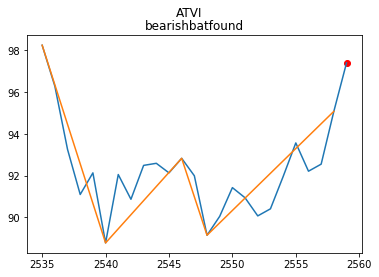

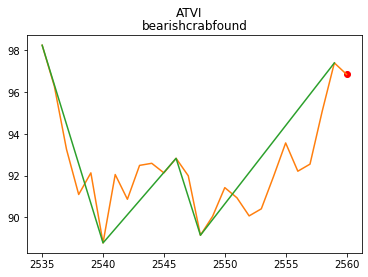

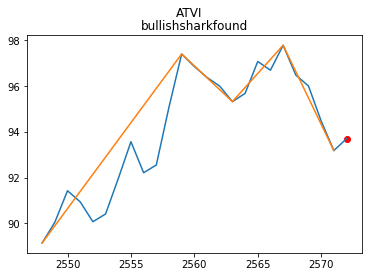

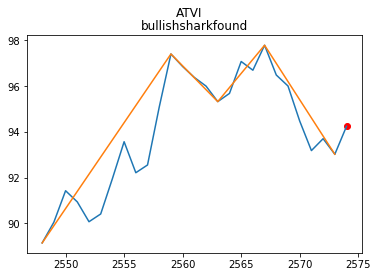

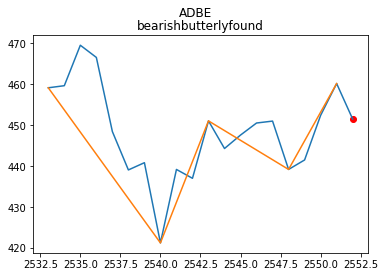

KeyboardInterrupt: 

In [66]:
%%time
#df_resultats = pd.DataFrame(index=['TimeFrame 1','TimeFrame2','Equity','Nbre Winners','Nbre Loosers','Average lenght of trade','Cumul pnl'])

#TICKERS = con.get_instruments()
#TICKERS = [ 'EUR/USD','USD/JPY','GBP/USD','USD/CHF','EUR/CHF','AUD/USD','USD/CAD','NZD/USD','EUR/GBP','EUR/JPY','GBP/JPY','CHF/JPY','GBP/CHF','EUR/AUD','EUR/CAD','AUD/CAD','AUD/JPY','CAD/JPY','NZD/JPY','GBP/CAD','GBP/NZD','GBP/AUD','AUD/NZD','USD/SEK','EUR/SEK','EUR/NOK','USD/NOK','USD/MXN','AUD/CHF','EUR/NZD','USD/ZAR','ZAR/JPY','NZD/CHF','CAD/CHF','NZD/CAD','USD/ILS','USD/CNH']

engine.say("קדימה")
engine.runAndWait()
j = 0
k = 0
err_allowed = 5/100
pips = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
plt.ion()
position = 0
equity = 100000

#price = price.copy()

#price2 = price.copy()
#price3 = data3.copy()
_position = 0
_equity = 0
_nbtransactions = 0
backtest_graph = pd.DataFrame()
EQUITY = [_cash]
CASH = [_cash]
_winner = 0
_looser = 0
_index_entry = 0
TRADE_DURATION = []
_average_duration = 0
_size = 50000

PRICE_BUY = []
PRICE_SELL = []

_total = 0

_target = 0.0010
_sl = 0.030
_spread_filter = 0.00050
_filtre_multipoz = 0.1 # En %
_filtre_multipoz = _filtre_multipoz/100

_open_buy = 0
_open_sell = 0
_minipoz = 0

#MM21 = talib.EMA(price.Close, timeperiod=21)
#rsi = talib.RSI(price.Close, timeperiod=14)
rsi_high = 65
rsi_low = 35
#upperband, middleband, lowerband = talib.BBANDS(price.Close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
#fastk, fastd = talib.STOCHRSI(price.Close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)#STOCHASTICRSI
#slowk, slowd = talib.STOCH(price.High, price.Low, price.Close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)#STOCHASTIC

'''MM82 = talib.EMA(price2.Close, timeperiod=8)
MM212 = talib.EMA(price2.Close, timeperiod=21)
MM342 = talib.EMA(price2.Close, timeperiod=34)
rsi2 = talib.RSI(price2.Close, timeperiod=14)
upperband2, middleband2, lowerband2 = talib.BBANDS(price2.Close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
fastk2, fastd2 = talib.STOCHRSI(price2.Close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)#STOCHASTICRSI
slowk2, slowd2 = talib.STOCH(price2.High, price2.Low, price2.Close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
'''
'''MM83 = talib.EMA(price3.Close, timeperiod=8)
MM213 = talib.EMA(price3.Close, timeperiod=21)
MM343 = talib.EMA(price3.Close, timeperiod=34)
rsi3 = talib.RSI(price3.Close, timeperiod=14)
upperband3, middleband3, lowerband3 = talib.BBANDS(price3.Close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
fastk3, fastd3 = talib.STOCHRSI(price3.Close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)#STOCHASTICRSI
slowk3, slowd3 = talib.STOCH(price3.High, price3.Low, price3.Close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)'''
_grandcompteur =0
MINICOMPTEUR = []
for _ticker in df.Symbol.to_list():
    
    _minicompteur = 0   
    price = globals()['df_%s' %_ticker]['Adj Close']
    rsi = talib.RSI(price, timeperiod=14)
    for i in range(len(price)-50,len(price)-1):

        current_idx,current_pat,start,end = peak_detect(price.values[:i])

        XA = current_pat[1] - current_pat[0]
        AB = current_pat[2] - current_pat[1]
        BC = current_pat[3] - current_pat[2]
        CD = current_pat[4] - current_pat[3]


        moves=[XA,AB,BC,CD]

        gartley = is_gartley(moves,err_allowed)
        butterfly = is_butterfly(moves,err_allowed)
        crab = is_crab(moves,err_allowed)
        bat = is_bat(moves,err_allowed)
        shark = is_shark(moves,err_allowed)
        abcd = is_abcd(moves,err_allowed)

        current_rsi = [rsi.iloc[current_idx[0]],rsi.iloc[current_idx[1]],rsi.iloc[current_idx[2]],rsi.iloc[current_idx[3]],rsi.iloc[current_idx[4]]]
        current_rsi_max = max(current_rsi)
        current_rsi_min = min(current_rsi)
        delta_price = current_pat[4] - current_pat[2]
        delta_rsi = current_rsi[4] - current_rsi[2]


        harmonics = np.array([gartley,butterfly,bat,crab,shark,abcd])
        #harmonics = np.array([abcd])
        labels = ['gartley','butterly','bat','crab','shark','abcd']
        #labels = ['abcd']
        #if (np.any(harmonics==1) and delta_price<0 and delta_rsi>0) or (np.any(harmonics==-1) and delta_price>0 and delta_rsi<0):
        if np.any(harmonics==1) or np.any(harmonics==-1):

            for j in range(0, len(harmonics)):


                if harmonics[j]==1 or harmonics[j]==-1:
                    sense ='bearish' if harmonics[j]==-1 else 'bullish'
                    label =  sense + labels[j] +'found'
                    _minicompteur+=1


                    try:


                        plt.title(label)
                        #moves

                        plt.suptitle(i-current_idx[-1])
                        plt.suptitle(_ticker)
                            #plt.figure(figsize=(16,6))
                        plt.plot(np.arange(start,i+1),price.values[start:i+1])
                        #plt.plot(np.arange(start,i+15),rsi.values[start:i+15])
                        plt.scatter(x=i,y=price.values[i],c = "red")
                        plt.plot(current_idx,current_pat)
                        plt.show()
                    except:
                        continue
                       
                  
    MINICOMPTEUR.append(_minicompteur)
    _grandcompteur+=_minicompteur
print(_grandcompteur)
print(MINICOMPTEUR)


In [79]:
df_GOOGL[((df_GOOGL['Adj Close'] >= 2100)&(df_GOOGL['Adj Close'] <= 2250))]

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-02-16,2145.139893,2091.750000,2091.750000,2110.699951,1550200.0,2110.699951
2021-02-17,2122.439941,2088.350098,2093.979980,2118.620117,1014700.0,2118.620117
2021-02-18,2121.989990,2093.330078,2105.000000,2105.810059,1127300.0,2105.810059
2021-03-11,2111.270020,2056.449951,2058.219971,2100.540039,1385100.0,2100.540039
2021-04-01,2135.750000,2091.429932,2092.250000,2129.780029,1994000.0,2129.780029
2021-04-05,2228.989990,2145.209961,2147.149902,2218.959961,2425500.0,2218.959961
2021-04-06,2228.000000,2201.790039,2210.919922,2209.260010,1762000.0,2209.260010
2021-04-07,2244.500000,2213.100098,2213.100098,2239.030029,1206700.0,2239.030029
2021-04-12,2256.889893,2227.820068,2254.120117,2244.620117,1251200.0,2244.620117


In [67]:
_ticker

'AMD'

In [33]:
#find extrema

err_allowed = 10/100
pips = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
#plt.ion()
price = price.Close.copy()

In [58]:
len(df_ATO)

2596

In [60]:
current_pat

array([299.33999634, 279.73001099, 285.76000977, 269.54000854,
       277.63000488])

In [25]:
df_D1.shape

(2937, 13)

In [ ]:
for i in range(100,len(price)):
    
    current_idx,current_pat,start,end = peak_detect(price.values[:i])
    
    XA = current_pat[1] - current_pat[0]
    AB = current_pat[2] - current_pat[1]
    BC = current_pat[3] - current_pat[2]
    CD = current_pat[4] - current_pat[3]
    XB = current_pat[2] - current_pat[0]

    moves=[XA,AB,BC,CD,XB]

    gartley = is_gartley(moves,err_allowed)
    butterfly = is_butterfly(moves,err_allowed)
    crab = is_crab(moves,err_allowed)
    bat = is_bat(moves,err_allowed)
    shark = is_shark(moves,err_allowed)
    
    harmonics = np.array([gartley,butterfly,bat,crab,shark])
    labels = ['gartley','butterly','bat','crab','shark']
    if np.any(harmonics==1) or np.any(harmonics==-1 ):
        
        for j in range(0, len(harmonics)):
                
            if harmonics[j]==1 or harmonics[j]==-1:
                sense ='bearish' if harmonics[j]==-1 else 'bullish'
                label =  sense + labels[j] +'found'
                
                
                plt.title(label)
                  #plt.figure(figsize=(16,6))
                plt.plot(np.arange(start,i+15),price.values[start:i+15])
                plt.plot(current_idx,current_pat)
                plt.show()